In [ ]:
import pandas as pd
import numpy as np
import os
from joblib import Parallel, delayed
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms

# Transforms for ResNet (224x224)
my_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

class MyImageDataset(Dataset):
    def __init__(self, parquet_path, transform=None):
        """
        parquet_path: path to the Parquet file with columns [filepath, label].
        transform: optional torchvision transforms.
        """
        # Load the Parquet file into a DataFrame
        self.data = pd.read_parquet(parquet_path)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        img_path = row['filepath']
        label = row['label']  # 0 or 1

        # Open the image and convert it to RGB
        image = Image.open(img_path).convert('RGB')

        # Apply transforms if provided
        if self.transform:
            image = self.transform(image)

        # Convert label to a tensor
        label = torch.tensor(label, dtype=torch.long)

        return image, label

In [ ]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

parquet_file = 'train_data_path.parquet'  # The Parquet file you created
train_dataset = MyImageDataset(parquet_file, transform=my_transform)

train_loader = DataLoader(
    train_dataset,
    batch_size=128,      # adjust based on GPU memory
    shuffle=True,       # randomize order of samples
    num_workers=12,      # use multiple CPU cores to speed up loading
    pin_memory=True
)


parquet_file = 'val_data_path.parquet'  # The Parquet file you created
val_dataset = MyImageDataset(parquet_file, transform=my_transform)

val_loader = DataLoader(
    val_dataset,
    batch_size=128,      # adjust based on GPU memory
    shuffle=True,       # randomize order of samples
    num_workers=12,      # use multiple CPU cores to speed up loading
    pin_memory=True
)

In [ ]:
import time
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet34
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import CosineAnnealingLR

# -----------------------------
# 1) Hyperparameters & Setup
# -----------------------------
EPOCHS = 100
EARLY_STOP_PATIENCE = 10
LR = 1e-4
WEIGHT_DECAY = 1e-5
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
CHECKPOINT_DIR = './checkpoints_simple'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Create a TensorBoard writer
writer = SummaryWriter(log_dir='runs/resnet34_simple')

# -----------------------------
# 2) Model, Loss, Optimizer, Scheduler
# -----------------------------
model = resnet34(pretrained=False)
# ResNet34 default final layer has 1000 outputs; replace with 2 for binary classification
model.fc = nn.Linear(model.fc.in_features, 2)
model.to(DEVICE)

criterion = nn.CrossEntropyLoss().to(DEVICE)  # Moved criterion to the same device
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=0)

# -----------------------------
# 3) Helper to compute accuracy
# -----------------------------
def compute_accuracy(outputs, labels):
    """
    outputs: (batch_size, 2) raw logits
    labels: (batch_size,) ground truth in {0,1}
    returns accuracy in [0..1].
    """
    preds = outputs.argmax(dim=1)
    correct = (preds == labels).sum().item()
    total = labels.size(0)
    return correct / total

# -----------------------------
# 4) Training & Validation Loop
# -----------------------------
best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(1, EPOCHS + 1):
    start_time = time.time()

    # ========== TRAIN ==========
    model.train()
    train_loss, train_correct, train_samples = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # Forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        batch_size = labels.size(0)
        train_loss += loss.item() * batch_size
        train_correct += (outputs.argmax(dim=1) == labels).sum().item()
        train_samples += batch_size

    avg_train_loss = train_loss / train_samples
    avg_train_acc  = train_correct / train_samples

    # ========== VALIDATION ==========
    model.eval()
    val_loss, val_correct, val_samples = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)

            batch_size = labels.size(0)
            val_loss += loss.item() * batch_size
            val_correct += (outputs.argmax(dim=1) == labels).sum().item()
            val_samples += batch_size

    avg_val_loss = val_loss / val_samples
    avg_val_acc  = val_correct / val_samples

    # ========== LOGGING ==========
    writer.add_scalar('Loss/Train', avg_train_loss, epoch)
    writer.add_scalar('Loss/Val',   avg_val_loss,   epoch)
    writer.add_scalar('Acc/Train',  avg_train_acc,  epoch)
    writer.add_scalar('Acc/Val',    avg_val_acc,    epoch)

    elapsed = time.time() - start_time
    print(f"Epoch {epoch}/{EPOCHS} "
          f"Train Loss: {avg_train_loss:.4f} Acc: {avg_train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} Acc: {avg_val_acc:.4f} | "
          f"Time: {elapsed:.1f}s")

    # ========== CHECKPOINT (Saving More Info) ==========
    checkpoint_dict = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'best_val_loss': best_val_loss
    }
    checkpoint_path = os.path.join(CHECKPOINT_DIR, f"resnet34_epoch{epoch}.pth")
    torch.save(checkpoint_dict, checkpoint_path)
    print(f"  --> Saved checkpoint to {checkpoint_path}")

    # ========== EARLY STOPPING + SAVE BEST MODEL ==========
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0

        # Save the best model so far (same extra info)
        best_checkpoint_dict = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_val_loss': best_val_loss
        }
        torch.save(best_checkpoint_dict, os.path.join(CHECKPOINT_DIR, "best_model.pth"))
        print(f"  --> New best model saved (val_loss={avg_val_loss:.4f})")
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= EARLY_STOP_PATIENCE:
        print(f"Early stopping at epoch {epoch}. Best val_loss={best_val_loss:.4f}")
        break

    # Step the scheduler at the end of each epoch
    scheduler.step()

# End of training
writer.close()
print("Training complete!")

/root/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/100 Train Loss: 0.6930 Acc: 0.5147 | Val Loss: 0.6948 Acc: 0.5085 | Time: 3232.3s
  --> Saved checkpoint to ./checkpoints_simple/resnet34_epoch1.pth
  --> New best model saved (val_loss=0.6948)
Epoch 2/100 Train Loss: 0.6896 Acc: 0.5290 | Val Loss: 0.6987 Acc: 0.4994 | Time: 3233.9s
  --> Saved checkpoint to ./checkpoints_simple/resnet34_epoch2.pth
Epoch 3/100 Train Loss: 0.6844 Acc: 0.5405 | Val Loss: 0.6978 Acc: 0.5081 | Time: 3236.7s
  --> Saved checkpoint to ./checkpoints_simple/resnet34_epoch3.pth
Epoch 4/100 Train Loss: 0.6797 Acc: 0.5496 | Val Loss: 0.6991 Acc: 0.5037 | Time: 3232.9s
  --> Saved checkpoint to ./checkpoints_simple/resnet34_epoch4.pth


After your code finishes (or even while it’s still training), open a terminal (or a separate notebook cell) and run:
tensorboard --logdir=Downloads/runs/resnet34_simple
Then, in your web browser, go to:
http://localhost:6006
You’ll see the TensorBoard UI, where you can view the train/val loss and train/val accuracy curves under the “Scalars” tab.

Loading a Checkpoint to Resume Training(same lr scheduler)

In [ ]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet34
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.tensorboard import SummaryWriter

# 1) Decide which device to use
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
CHECKPOINT_DIR = './checkpoints_simple'

# 2) Load the checkpoint from disk
checkpoint_path = os.path.join(CHECKPOINT_DIR, 'resnet34_epoch6.pth')
checkpoint = torch.load(checkpoint_path, map_location=DEVICE)

# 3) Rebuild the same model architecture
model_resumed = resnet34(pretrained=False)
model_resumed.fc = nn.Linear(model_resumed.fc.in_features, 2)  # 2-class final layer
model_resumed.to(DEVICE)

# 4) Rebuild optimizer & schedule
criterion_resumed = nn.CrossEntropyLoss().to(DEVICE)
optimizer_resumed = optim.AdamW(model_resumed.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler_resumed = CosineAnnealingLR(optimizer_resumed, T_max=10, eta_min=0)

# 5) Load the saved states
model_resumed.load_state_dict(checkpoint['model_state_dict'])
optimizer_resumed.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler_resumed.load_state_dict(checkpoint['scheduler_state_dict'])

start_epoch = checkpoint['epoch'] + 1
best_val_loss = checkpoint['best_val_loss']

print(f"Resuming training from epoch {start_epoch}, best_val_loss so far: {best_val_loss:.4f}")

# 6) Set up TensorBoard writer
# You can change 'runs/resnet34_resume' to any folder you like
writer = SummaryWriter(log_dir='runs/resnet34_resume')

# 7) Continue training loop
EPOCHS = 10  # or however many total epochs you want to run now

for epoch in range(start_epoch, EPOCHS + 1):
    start_time = time.time()

    # ---------- TRAIN ----------
    model_resumed.train()
    train_loss, train_correct, train_samples = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        outputs = model_resumed(images)
        loss = criterion_resumed(outputs, labels)

        optimizer_resumed.zero_grad()
        loss.backward()
        optimizer_resumed.step()

        batch_size = labels.size(0)
        train_loss += loss.item() * batch_size
        train_correct += (outputs.argmax(dim=1) == labels).sum().item()
        train_samples += batch_size

    avg_train_loss = train_loss / train_samples
    avg_train_acc  = train_correct / train_samples

    # ---------- VALID ----------
    model_resumed.eval()
    val_loss, val_correct, val_samples = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            outputs = model_resumed(images)
            loss = criterion_resumed(outputs, labels)

            batch_size = labels.size(0)
            val_loss += loss.item() * batch_size
            val_correct += (outputs.argmax(dim=1) == labels).sum().item()
            val_samples += batch_size

    avg_val_loss = val_loss / val_samples
    avg_val_acc  = val_correct / val_samples

    elapsed = time.time() - start_time
    print(f"Epoch {epoch}/{EPOCHS} | "
          f"Train Loss: {avg_train_loss:.4f}, Acc: {avg_train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f}, Acc: {avg_val_acc:.4f} | "
          f"Time: {elapsed:.1f}s")

    # ---------- TensorBoard Logging ----------
    writer.add_scalar('Loss/Train', avg_train_loss, epoch)
    writer.add_scalar('Loss/Val',   avg_val_loss,   epoch)
    writer.add_scalar('Acc/Train',  avg_train_acc,  epoch)
    writer.add_scalar('Acc/Val',    avg_val_acc,    epoch)

    # ---------- Save a checkpoint each epoch ----------
    checkpoint_dict = {
        'epoch': epoch,
        'model_state_dict': model_resumed.state_dict(),
        'optimizer_state_dict': optimizer_resumed.state_dict(),
        'scheduler_state_dict': scheduler_resumed.state_dict(),
        'best_val_loss': best_val_loss
    }

    epoch_ckpt_path = os.path.join(CHECKPOINT_DIR, f"resnet34_epoch{epoch}.pth")
    torch.save(checkpoint_dict, epoch_ckpt_path)
    print(f"  --> Saved checkpoint: {epoch_ckpt_path}")

    # ---------- If improved, save best model ----------
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        print(f"  --> New best val_loss: {best_val_loss:.4f}")
        torch.save(checkpoint_dict, os.path.join(CHECKPOINT_DIR, "best_model.pth"))
        print(f"  --> Saved best model: {os.path.join(CHECKPOINT_DIR, 'best_model.pth')}")

    # ---------- Step scheduler ----------
    scheduler_resumed.step()

print("Resumed training complete!")
writer.close()
print("TensorBoard writer closed.")

Resume traning using fixed lr 1e-5

In [ ]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet34
from torch.utils.tensorboard import SummaryWriter

# 1) Decide which device to use
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
CHECKPOINT_DIR = './checkpoints_simple'

# 2) Load the checkpoint from disk (epoch 7 checkpoint)
checkpoint_path = os.path.join(CHECKPOINT_DIR, 'resnet34_epoch7.pth')
checkpoint = torch.load(checkpoint_path, map_location=DEVICE)

# 3) Rebuild the same model architecture
model_resumed = resnet34(pretrained=False)
model_resumed.fc = nn.Linear(model_resumed.fc.in_features, 2)  # 2-class final layer
model_resumed.to(DEVICE)

# 4) Build criterion and optimizer (with desired fixed lr=1e-5)
criterion_resumed = nn.CrossEntropyLoss().to(DEVICE)
optimizer_resumed = optim.AdamW(model_resumed.parameters(), lr=1e-5, weight_decay=1e-5)

# 5) Load the saved states for the model and optimizer
model_resumed.load_state_dict(checkpoint['model_state_dict'])
optimizer_resumed.load_state_dict(checkpoint['optimizer_state_dict'])
# Override the learning rate to fixed 1e-5 for all param groups
for param_group in optimizer_resumed.param_groups:
    param_group['lr'] = 1e-5

# Note: We are not using a scheduler since we want a fixed learning rate

start_epoch = checkpoint['epoch'] + 1  # will start from epoch 8
best_val_loss = checkpoint['best_val_loss']

print(f"Resuming training from epoch {start_epoch}, best_val_loss so far: {best_val_loss:.4f}")

# 6) Set up TensorBoard writer
writer = SummaryWriter(log_dir='runs/resnet34_resume_fixed_lr')

# 7) Continue training loop
EPOCHS = 10  # Total epochs you want to run (adjust as needed)

for epoch in range(start_epoch, EPOCHS + 1):
    start_time = time.time()

    # ---------- TRAIN ----------
    model_resumed.train()
    train_loss, train_correct, train_samples = 0.0, 0, 0

    for images, labels in train_loader:  # Ensure train_loader is defined
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        outputs = model_resumed(images)
        loss = criterion_resumed(outputs, labels)

        optimizer_resumed.zero_grad()
        loss.backward()
        optimizer_resumed.step()

        batch_size = labels.size(0)
        train_loss += loss.item() * batch_size
        train_correct += (outputs.argmax(dim=1) == labels).sum().item()
        train_samples += batch_size

    avg_train_loss = train_loss / train_samples
    avg_train_acc  = train_correct / train_samples

    # ---------- VALID ----------
    model_resumed.eval()
    val_loss, val_correct, val_samples = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:  # Ensure val_loader is defined
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            outputs = model_resumed(images)
            loss = criterion_resumed(outputs, labels)

            batch_size = labels.size(0)
            val_loss += loss.item() * batch_size
            val_correct += (outputs.argmax(dim=1) == labels).sum().item()
            val_samples += batch_size

    avg_val_loss = val_loss / val_samples
    avg_val_acc  = val_correct / val_samples

    elapsed = time.time() - start_time
    print(f"Epoch {epoch}/{EPOCHS} | "
          f"Train Loss: {avg_train_loss:.4f}, Acc: {avg_train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f}, Acc: {avg_val_acc:.4f} | "
          f"Time: {elapsed:.1f}s")

    # ---------- TensorBoard Logging ----------
    writer.add_scalar('Loss/Train', avg_train_loss, epoch)
    writer.add_scalar('Loss/Val',   avg_val_loss,   epoch)
    writer.add_scalar('Acc/Train',  avg_train_acc,  epoch)
    writer.add_scalar('Acc/Val',    avg_val_acc,    epoch)

    # ---------- Save a checkpoint each epoch ----------
    checkpoint_dict = {
        'epoch': epoch,
        'model_state_dict': model_resumed.state_dict(),
        'optimizer_state_dict': optimizer_resumed.state_dict(),
        'best_val_loss': best_val_loss
    }

    epoch_ckpt_path = os.path.join(CHECKPOINT_DIR, f"resnet34_epoch{epoch}.pth")
    torch.save(checkpoint_dict, epoch_ckpt_path)
    print(f"  --> Saved checkpoint: {epoch_ckpt_path}")

    # ---------- If improved, save best model ----------
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        print(f"  --> New best val_loss: {best_val_loss:.4f}")
        best_model_path = os.path.join(CHECKPOINT_DIR, "best_model.pth")
        torch.save(checkpoint_dict, best_model_path)
        print(f"  --> Saved best model: {best_model_path}")

print("Resumed training complete!")
writer.close()
print("TensorBoard writer closed.")

Resuming training from epoch 8, best_val_loss so far: 0.6836
Epoch 8/10 | Train Loss: 0.6686, Acc: 0.5702 | Val Loss: 0.6827, Acc: 0.5466 | Time: 3239.3s
  --> Saved checkpoint: ./checkpoints_simple/resnet34_epoch8.pth
  --> New best val_loss: 0.6827
  --> Saved best model: ./checkpoints_simple/best_model.pth
Epoch 9/10 | Train Loss: 0.6655, Acc: 0.5748 | Val Loss: 0.6842, Acc: 0.5468 | Time: 3236.0s
  --> Saved checkpoint: ./checkpoints_simple/resnet34_epoch9.pth
Epoch 10/10 | Train Loss: 0.6631, Acc: 0.5789 | Val Loss: 0.6853, Acc: 0.5465 | Time: 3224.3s
  --> Saved checkpoint: ./checkpoints_simple/resnet34_epoch10.pth
Resumed training complete!
TensorBoard writer closed.


test model

In [ ]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

parquet_file = 'test_data_path.parquet'  # The Parquet file you created
test_dataset = MyImageDataset(parquet_file, transform=my_transform)

test_loader = DataLoader(
    test_dataset,
    batch_size=128,      # adjust based on GPU memory
    shuffle=False,       # randomize order of samples
    num_workers=12,      # use multiple CPU cores to speed up loading
    pin_memory=True
)

/root/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Test Loss: 0.7050
Test Accuracy: 0.5082
Test F1 Score: 0.5008


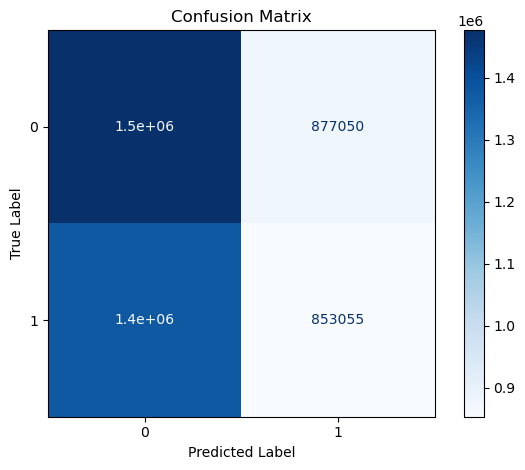

In [ ]:
import os
import torch
import torch.nn as nn
from torchvision.models import resnet34
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

# -----------------------------
# 1) Device & Checkpoint Setup
# -----------------------------
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
CHECKPOINT_DIR = './checkpoints_simple'
checkpoint_path = os.path.join(CHECKPOINT_DIR, 'best_model.pth')

# Load the checkpoint saved at epoch 7
checkpoint = torch.load(checkpoint_path, map_location=DEVICE)

# -----------------------------
# 2) Rebuild Model & Load State
# -----------------------------
model = resnet34(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 2)  # for binary classification
model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE)
model.eval()  # set model to evaluation mode

# Define the loss criterion
criterion = nn.CrossEntropyLoss().to(DEVICE)

# -----------------------------
# 3) Evaluate on Test Data
# -----------------------------
test_loss = 0.0
test_correct = 0
test_samples = 0
all_preds = []
all_labels = []

with torch.inference_mode():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * labels.size(0)

        preds = outputs.argmax(dim=1)
        test_correct += (preds == labels).sum().item()
        test_samples += labels.size(0)

        # Store predictions and true labels for further metrics
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

avg_test_loss = test_loss / test_samples
test_accuracy = test_correct / test_samples
test_f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# -----------------------------
# 3) Plot Confusion Matrix
# -----------------------------
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

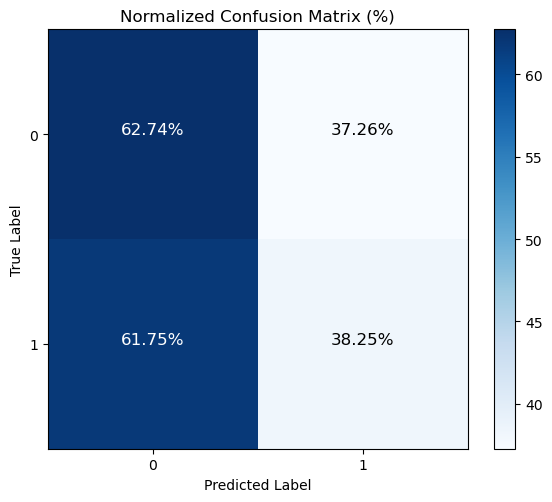

In [ ]:
# Compute confusion matrix (using raw counts)
cm = confusion_matrix(all_labels, all_preds)
# Normalize by row (true labels) to get percentages
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_perc = np.round(cm_norm * 100, decimals=2)

# Plot the confusion matrix using matplotlib
plt.figure(figsize=(6, 5))
plt.imshow(cm_perc, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Normalized Confusion Matrix (%)")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['0', '1'])
plt.yticks(tick_marks, ['0', '1'])

# Add text annotations in each cell
for i in range(cm_perc.shape[0]):
    for j in range(cm_perc.shape[1]):
        plt.text(j, i, f"{cm_perc[i, j]}%", horizontalalignment="center",
                 color="white" if cm_perc[i, j] > 50 else "black", fontsize=12)

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

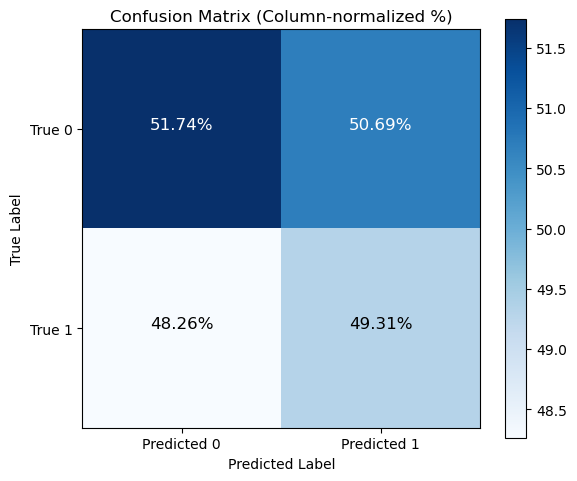

In [ ]:
# Compute confusion matrix (using raw counts)
cm = confusion_matrix(all_labels, all_preds)

# Normalize by predicted labels (columns) to get percentages:
# For each column j, divide each element by the column sum.
cm_norm = cm.astype('float') / cm.sum(axis=0)[np.newaxis, :]
cm_perc = np.round(cm_norm * 100, decimals=2)

# Plot the confusion matrix using matplotlib
plt.figure(figsize=(6, 5))
plt.imshow(cm_perc, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Column-normalized %)")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Predicted 0', 'Predicted 1'])
plt.yticks(tick_marks, ['True 0', 'True 1'])

# Add text annotations in each cell
for i in range(cm_perc.shape[0]):
    for j in range(cm_perc.shape[1]):
        plt.text(j, i, f"{cm_perc[i, j]}%", horizontalalignment="center",
                 color="white" if cm_perc[i, j] > 50 else "black", fontsize=12)

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()